In [4]:
import os
file_paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_paths.append(os.path.join(dirname, filename))
print(f"Total files found: {len(file_paths)}")

Total files found: 1


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [24]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
df = pd.read_csv('/kaggle/input/5g-quality-of-service/Quality of Service 5G.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')
label_encoder = LabelEncoder()
df['App_Type_Encoded'] = label_encoder.fit_transform(df['Application_Type'])
df['Signal_Strength'] = df['Signal_Strength'].str.replace('dBm', '', regex=False).astype(float)
df['Latency'] = df['Latency'].str.replace('ms', '', regex=False).astype(float)
def convert_bandwidth(value):
    value = str(value).strip()
    if 'Mbps' in value:
        return float(value.replace('Mbps', '').strip())
    elif 'Kbps' in value:
        return float(value.replace('Kbps', '').strip()) / 1000.0
    else:
        return float(value)  
df['Required_Bandwidth'] = df['Required_Bandwidth'].apply(convert_bandwidth)
df['Allocated_Bandwidth'] = df['Allocated_Bandwidth'].apply(convert_bandwidth)
df['Resource_Allocation'] = df['Resource_Allocation'].str.replace('%', '', regex=False).astype(float) / 100.0
scaler = MinMaxScaler()
df[['Signal_Strength', 'Latency', 'Required_Bandwidth', 'Allocated_Bandwidth', 'Resource_Allocation']] = \
    scaler.fit_transform(df[['Signal_Strength', 'Latency', 'Required_Bandwidth', 'Allocated_Bandwidth', 'Resource_Allocation']])
features = ['Signal_Strength', 'Latency', 'App_Type_Encoded', 'Required_Bandwidth', 'Allocated_Bandwidth']
target = 'Resource_Allocation'

In [52]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Early stopping setup
best_val_loss = float('inf')
patience = 10
counter = 0

# Define sequence length and features
sequence_length = 10
features = ['Signal_Strength', 'Latency', 'App_Type_Encoded', 'Required_Bandwidth', 'Allocated_Bandwidth']
target_col = 'Resource_Allocation'

# Create sequences from entire dataset
def create_sequences(data, target, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = target[i+seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create the sequences
X, y = create_sequences(df[features].values, df[target_col].values, sequence_length)

# Time-series based split (80% train+val, 20% test)
trainval_len = int(len(X) * 0.8)
X_trainval, X_test = X[:trainval_len], X[trainval_len:]
y_trainval, y_test = y[:trainval_len], y[trainval_len:]

# Time-series split within trainval: 80% train, 20% val
train_len = int(len(X_trainval) * 0.8)
X_train, X_val = X_trainval[:train_len], X_trainval[train_len:]
y_train, y_val = y_trainval[:train_len], y_trainval[train_len:]

# Dataset class
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# DataLoaders
train_dataset = SequenceDataset(X_train, y_train)
val_dataset = SequenceDataset(X_val, y_val)
test_dataset = SequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# LSTM Model
class LSTMResourcePredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out.squeeze()

# Initialize model
model = LSTMResourcePredictor(input_size=len(features))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            val_losses.append(loss.item())

    val_loss_epoch = np.mean(val_losses)
    print(f"Epoch {epoch+1}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {val_loss_epoch:.4f}")

    # Early stopping
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1, Train Loss: 0.3555, Val Loss: 0.1246
Epoch 2, Train Loss: 0.0820, Val Loss: 0.0854
Epoch 3, Train Loss: 0.0642, Val Loss: 0.0625
Epoch 4, Train Loss: 0.0619, Val Loss: 0.0566
Epoch 5, Train Loss: 0.0531, Val Loss: 0.0542
Epoch 6, Train Loss: 0.0540, Val Loss: 0.0523
Epoch 7, Train Loss: 0.0527, Val Loss: 0.0531
Epoch 8, Train Loss: 0.0519, Val Loss: 0.0521
Epoch 9, Train Loss: 0.0519, Val Loss: 0.0520
Epoch 10, Train Loss: 0.0517, Val Loss: 0.0521
Epoch 11, Train Loss: 0.0515, Val Loss: 0.0518
Epoch 12, Train Loss: 0.0514, Val Loss: 0.0518
Epoch 13, Train Loss: 0.0513, Val Loss: 0.0518
Epoch 14, Train Loss: 0.0511, Val Loss: 0.0517
Epoch 15, Train Loss: 0.0510, Val Loss: 0.0516
Epoch 16, Train Loss: 0.0509, Val Loss: 0.0516
Epoch 17, Train Loss: 0.0508, Val Loss: 0.0515
Epoch 18, Train Loss: 0.0508, Val Loss: 0.0515
Epoch 19, Train Loss: 0.0507, Val Loss: 0.0514
Epoch 20, Train Loss: 0.0506, Val Loss: 0.0514
Epoch 21, Train Loss: 0.0505, Val Loss: 0.0513
Epoch 22, Train Loss: 

Test MSE: 0.0372
Test MAE: 0.1500
Test R² Score: 0.2357


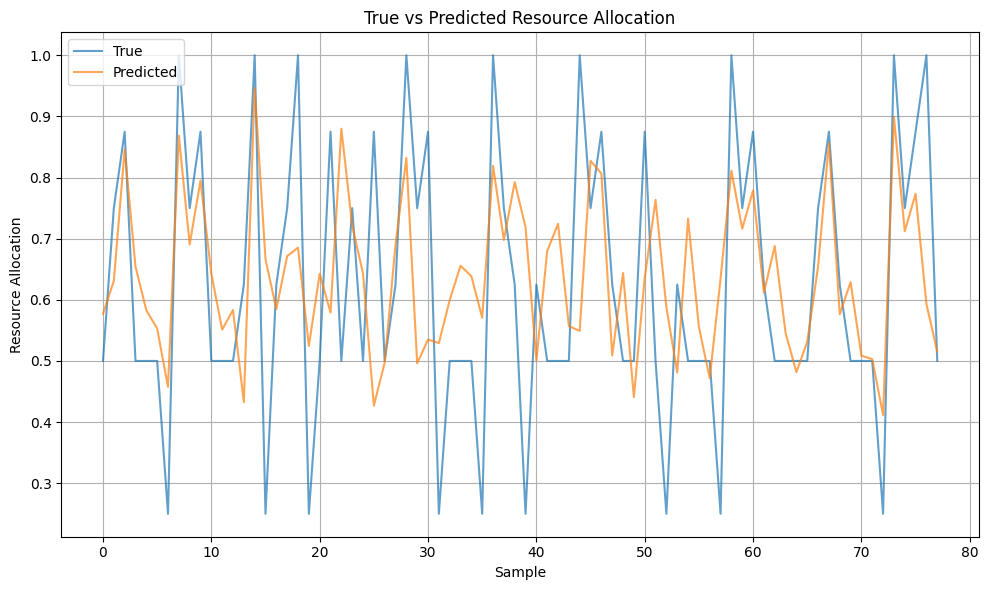

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds.numpy())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='True', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('True vs Predicted Resource Allocation')
plt.xlabel('Sample')
plt.ylabel('Resource Allocation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()